# 4: NPV Score 

### Import relevant packages 

In [7]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

### NPV_kaufen, NPV_mieten_und_investieren, NPV_delta, Score

In [8]:
def annuitaet_zahlung(kreditsumme: float, zins: float, tilgung: float) -> float:

    if kreditsumme <= 0:
        return 0.0
    if zins < 0 or tilgung < 0:
        raise ValueError("Zins und Tilgung müssen > 0 sein")

    return kreditsumme * (zins + tilgung)

def npv_kaufen(kaufpreis_pro_m2: float, zins: float, erwartete_rendite: float, tilgung: float, betrachtungszeitraum: int = 10, 
               wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
               verkaufskosten_quote: float = 0.05, instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,
               steuersatz_veraeusserungsgewinn: float = 0.25) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Initialwerte
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    # CF Betrachtung    
    cashflows = np.zeros(H + 1)
    # CF0
    cashflows[0] = -eigenkapital
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = max(0.0, restschuld - tilgung_t)
        instandhaltung_t = instandhaltung_quote * immowert_t
        cashflows[t] = -(zinsen_t + tilgung_t) - instandhaltung_t

    # CFH: CF bei Verkauf
    immowert_H = kaufpreis * (1.0 + preissteigerung_immobilie) ** H
    verkaufserloes_netto = immowert_H * (1.0 - verkaufskosten_quote)
    veraeusserungsgewinn = verkaufserloes_netto - anschaffungskosten

    steuer = 0.0
    if H < 10:
        steuer = max(0.0, veraeusserungsgewinn) * steuersatz_veraeusserungsgewinn

    cashflows[H] += (verkaufserloes_netto - steuer - restschuld)

    # Discounting Cash Flows
    diskontfaktoren = np.array([(1.0 + erwartete_rendite) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_mieten_und_investieren(mietpreis_pro_m2: float, rendite_invest: float, erwartete_rendite: float, betrachtungszeitraum: int = 10, 
                               wohnflaeche_m2: float = 80.0, mietsteigerung: float = 0.02, 
                               # Buy Parameter: 
                               kaufpreis_pro_m2: float = 0.0, zins: float = 0.0, tilgung: float = 0.0, eigenkapitalquote: float = 0.20, 
                               kaufnebenkosten_quote: float = 0.10, instandhaltung_quote: float = 0.01, 
                               preissteigerung_immobilie: float = 0.02,
                               # Steuer (Endbesteuerung auf Gewinn)
                               kapitalertragssteuer_satz: float = 0.26375,) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Budget = Annuität + Instandhaltungskosten 
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)

    # Initialmiete
    jahresmiete_0 = float(mietpreis_pro_m2) * float(wohnflaeche_m2) * 12.0

    # Initial-Investieren 
    vermoegen = float(eigenkapital)
    eingezahltes_geld = float(eigenkapital) # Summe der Einzahlungen ins Depot 

    # CF Betrachtung
    cashflows = np.zeros(H + 1, dtype=float)
    # CF0
    cashflows[0] = -float(eigenkapital)
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        # budget_t = Annuität + Instandhaltungskosten
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        instandhaltung_t = instandhaltung_quote * immowert_t
        budget_t = annuitaet + instandhaltung_t
        # Mietkosten + (Differenz) Investieren
        miete_t = jahresmiete_0 * (1.0 + mietsteigerung) ** (t - 1)
        sparen_t = budget_t - miete_t
        # Portfolioentwicklung
        vermoegen = vermoegen * (1.0 + rendite_invest) + sparen_t
        if sparen_t > 0:
            eingezahltes_geld += sparen_t

        # Budget als negativen Cashoutflow
        cashflows[t] = -budget_t

    # CFH: CF bei Verkauf
    gewinn = max(0.0, vermoegen - eingezahltes_geld)
    steuer = gewinn * float(kapitalertragssteuer_satz)
    vermoegen_netto = vermoegen - steuer

    cashflows[H] += vermoegen_netto
    # Discounting Cash Flows 
    diskontfaktoren = np.array([(1.0 + float(erwartete_rendite)) ** t for t in range(H + 1)], dtype=float)
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert


def npv_delta(kaufpreis_pro_m2: float, mietpreis_pro_m2: float, zins: float, tilgung: float, diskontsatz: float, rendite_invest: float,
    betrachtungszeitraum: int = 10, wohnflaeche_m2: float = 58.0, mietsteigerung: float = 0.02, kaufnebenkosten_quote: float = 0.10,
    eigenkapitalquote: float = 0.14, preissteigerung_immobilie: float = 0.03, instandhaltung_quote: float = 0.005,
    verkaufskosten_quote: float = 0.00, steuersatz_veraeusserungsgewinn: float = 0.25,) -> float:
   
    npv_buy = npv_kaufen(kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, erwartete_rendite=diskontsatz, 
                         betrachtungszeitraum=betrachtungszeitraum, wohnflaeche_m2=wohnflaeche_m2, 
                         kaufnebenkosten_quote=kaufnebenkosten_quote, eigenkapitalquote=eigenkapitalquote,
                         preissteigerung_immobilie=preissteigerung_immobilie, instandhaltung_quote=instandhaltung_quote, 
                         verkaufskosten_quote=verkaufskosten_quote, steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,)

    npv_rent_inv = npv_mieten_und_investieren(mietpreis_pro_m2=mietpreis_pro_m2, rendite_invest=rendite_invest, 
                                              erwartete_rendite=diskontsatz, betrachtungszeitraum=betrachtungszeitraum, 
                                              wohnflaeche_m2=wohnflaeche_m2, mietsteigerung=mietsteigerung, 
                                              kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, 
                                              eigenkapitalquote=eigenkapitalquote, kaufnebenkosten_quote=kaufnebenkosten_quote, 
                                              instandhaltung_quote=instandhaltung_quote, 
                                              preissteigerung_immobilie=preissteigerung_immobilie,)

    delta = npv_buy - npv_rent_inv
    return delta

def rent_vs_buy_score(delta_npv: float, scale: float) -> float:

    if scale <= 0:
        raise ValueError("scale must be positive")
    return float(np.tanh(delta_npv / scale))

In [9]:
BASE_DIR = Path("..") / "data" / "output"

df_empirica_regio = pd.read_csv(
    BASE_DIR / "empirica_regio_data.csv",
    encoding="utf-8-sig",
)
df_empirica_regio["Jahr"] = df_empirica_regio["Jahr"].astype(int)

df_macroeconomic_y = pd.read_csv(
    BASE_DIR / "macroeconomic_data_yearly.csv", 
    encoding="utf-8-sig",
)
df_macroeconomic_y["Jahr"] = df_macroeconomic_y["Jahr"].astype(int)

df_empirica_regio = df_empirica_regio[df_empirica_regio["Regionsebene"] == "Gemeinde"]

df_empirica_regio = df_empirica_regio.merge(df_macroeconomic_y, on=["Jahr"], how="left")

In [10]:
df_empirica_regio["Delta_NPV"] = df_empirica_regio.apply(
    lambda row: npv_delta(kaufpreis_pro_m2=row["Kaufpreis/m2 ETW 50%"], mietpreis_pro_m2=row["Mietpreis/m2 50%"], zins=row["Effektiver Jahreszins"], 
                          tilgung=0.02, diskontsatz=0.04, rendite_invest=0.08, betrachtungszeitraum=10, wohnflaeche_m2=58,
                          mietsteigerung=0.02, kaufnebenkosten_quote=0.1, eigenkapitalquote=0.14, 
                          preissteigerung_immobilie=0.02, instandhaltung_quote=0.005, verkaufskosten_quote=0, 
                          steuersatz_veraeusserungsgewinn=0.25),
    axis=1
)
df_empirica_regio = df_empirica_regio[["Regionsname", "Jahr", "Kaufpreis/m2 ETW 50%", "Mietpreis/m2 50%", "Wohneigentumsquote", "Effektiver Jahreszins", "Delta_NPV"]]
df_empirica_regio["Delta_NPV_rel"] = df_empirica_regio["Delta_NPV"] / (df_empirica_regio["Kaufpreis/m2 ETW 50%"] * 58 * (1.0 + 0.1))
# Scale 'S' nicht datengetrieben sondern fixiert (robustnesscheck later)
# choose 5% NPV advantage as 0.5 Score
S = 0.05 / np.arctanh(0.5)
df_empirica_regio["Score"] = np.tanh(df_empirica_regio["Delta_NPV_rel"] / S)

In [20]:
df_empirica_regio[df_empirica_regio["Score"] > 0.98]


,Regionsname,Jahr,Kaufpreis/m2 ETW 50%,Mietpreis/m2 50%,Wohneigentumsquote,Effektiver Jahreszins,Delta_NPV,Delta_NPV_rel,Score
8,Flensburg,2012,1060.0,5.51,27.8,0.031467,14572.189113,0.215476,0.982579
10,Flensburg,2014,1250.0,5.92,27.9,0.025408,16701.871382,0.209428,0.980128
12,Flensburg,2016,1488.0,6.54,28.0,0.018100,21578.270754,0.227297,0.986537
69,Neumünster,2010,880.0,5.11,38.6,0.037958,13204.968177,0.235198,0.988671
70,Neumünster,2011,848.0,5.16,38.6,0.039208,13936.012191,0.257586,0.993057
...,...,...,...,...,...,...,...,...,...
225791,Treben,2024,1000.0,5.71,NaN,0.038425,14060.992196,0.220392,0.984349
225826,Windischleuba,2017,750.0,4.77,63.6,0.018850,21449.272659,0.448261,0.999894
225827,Windischleuba,2018,947.0,5.64,63.6,0.019258,24069.402858,0.398377,0.999684
225830,Windischleuba,2021,1031.0,5.60,63.7,0.013017,25446.355438,0.386853,0.999593


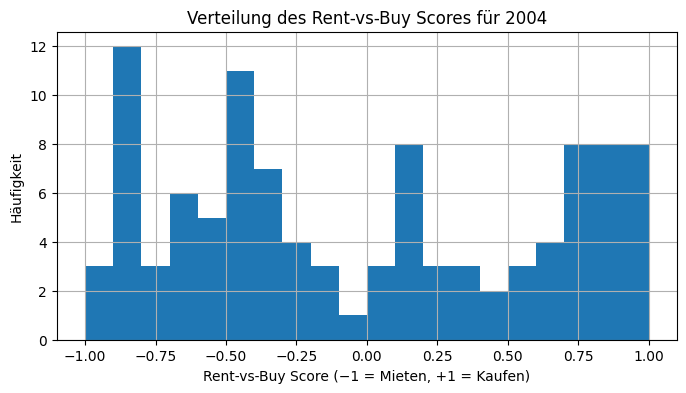

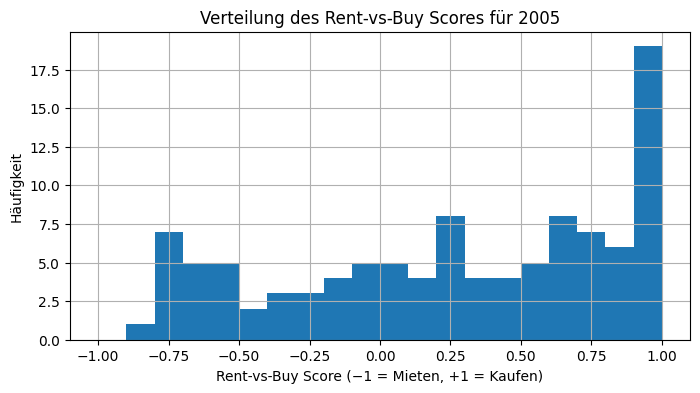

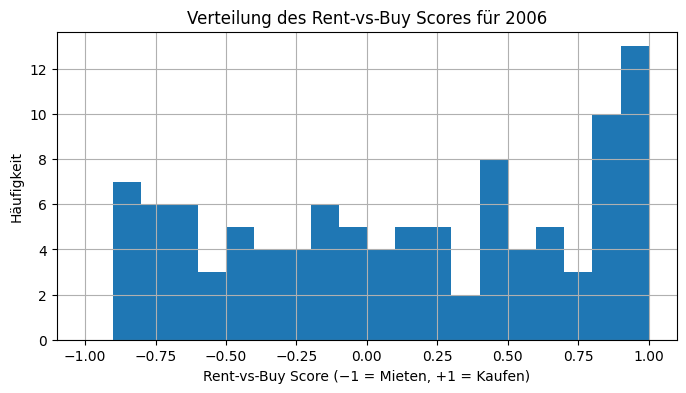

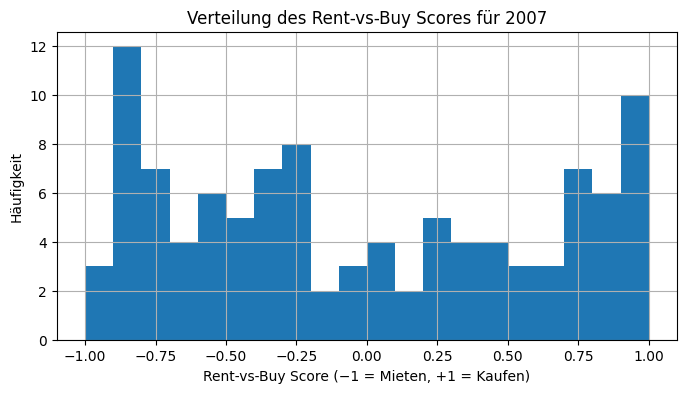

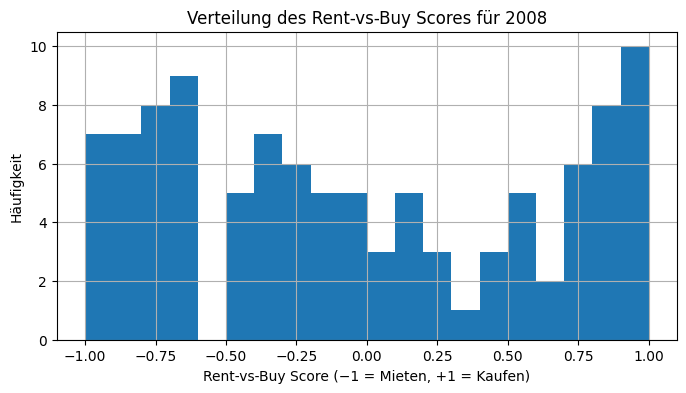

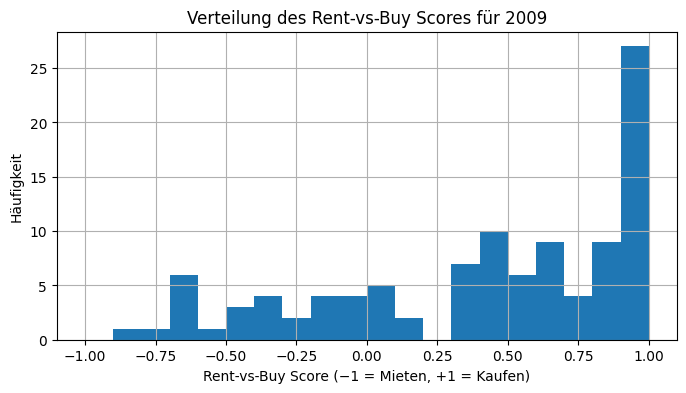

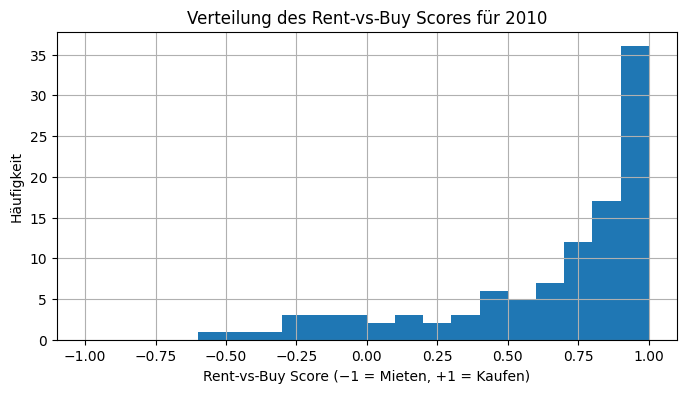

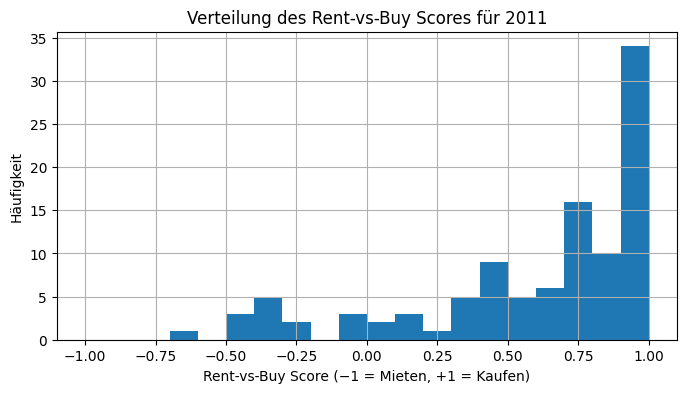

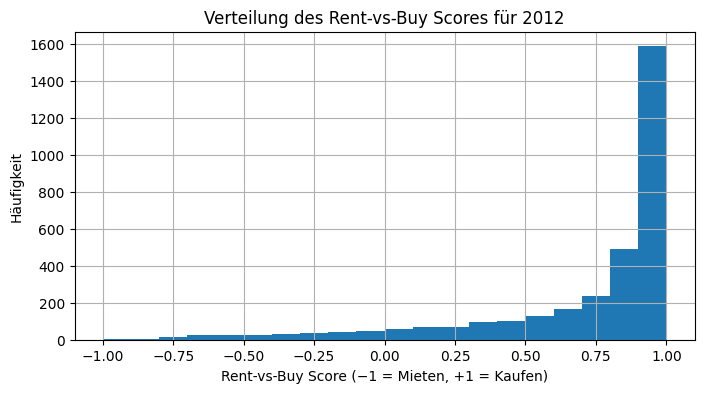

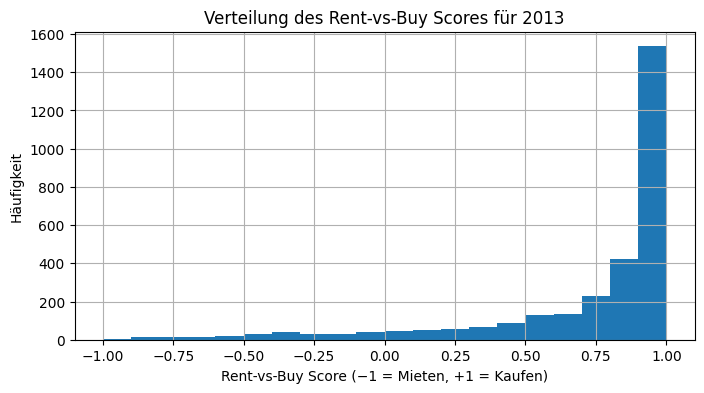

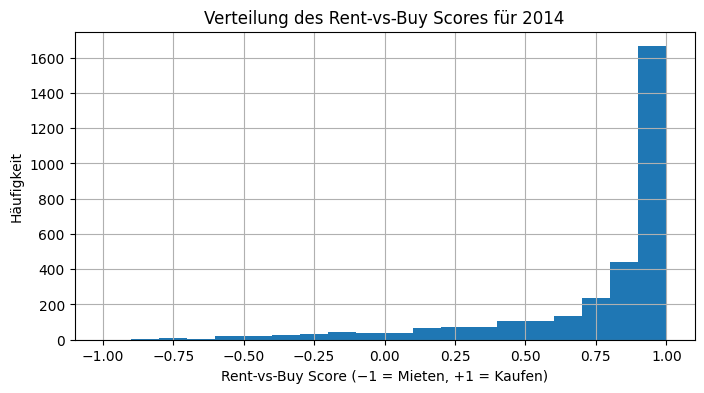

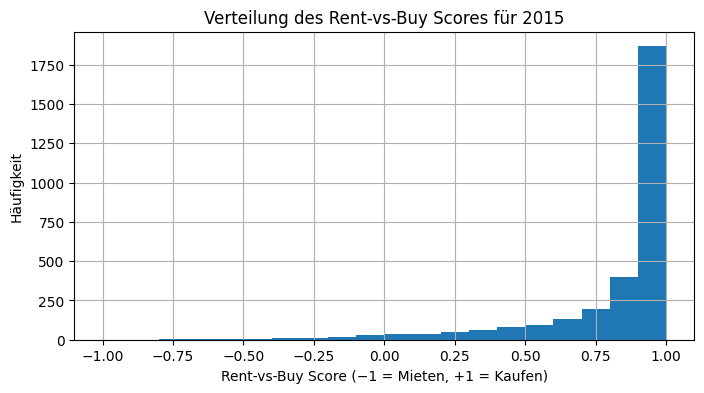

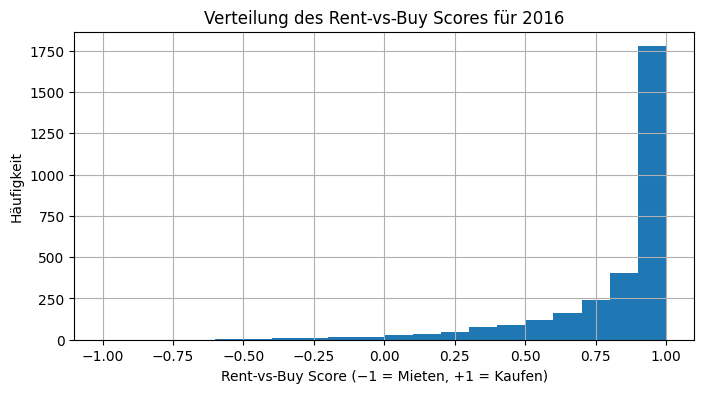

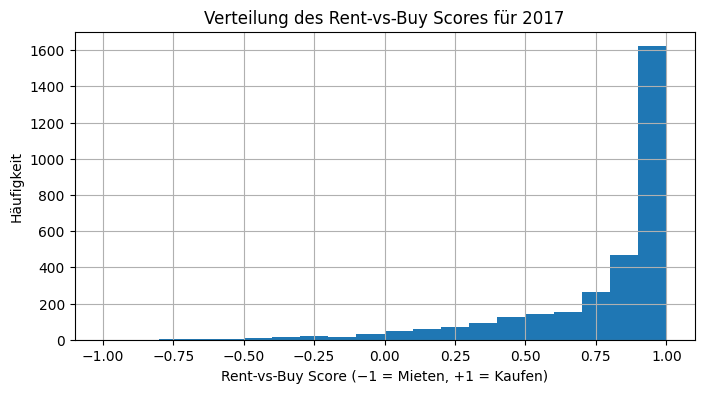

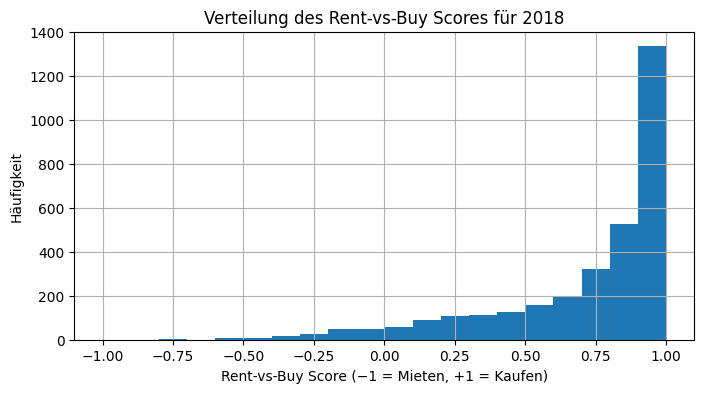

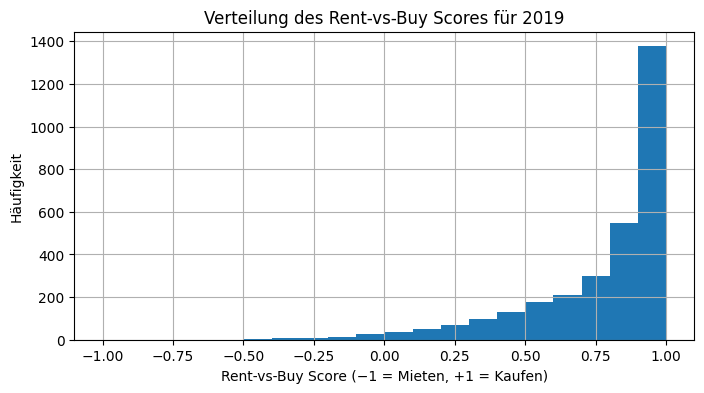

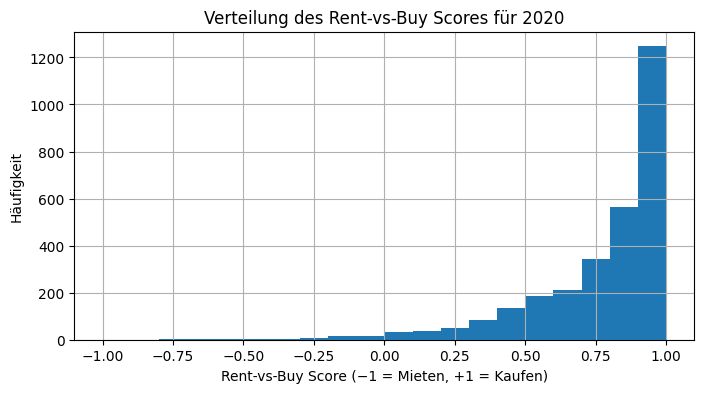

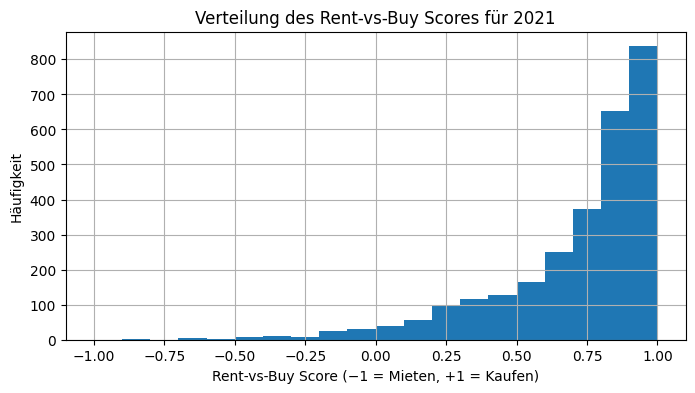

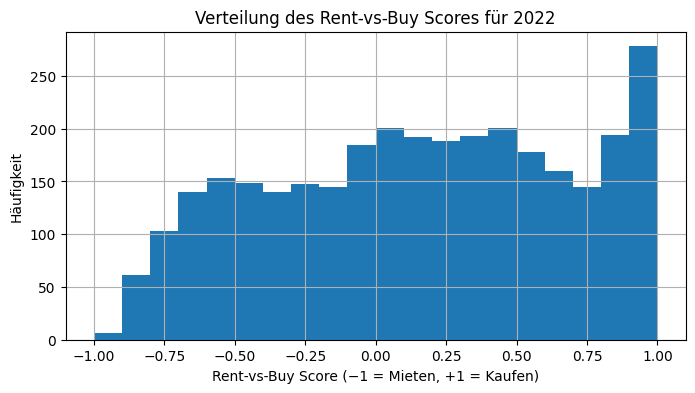

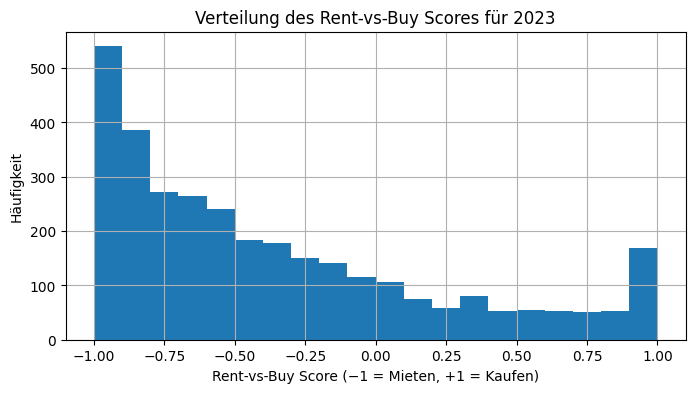

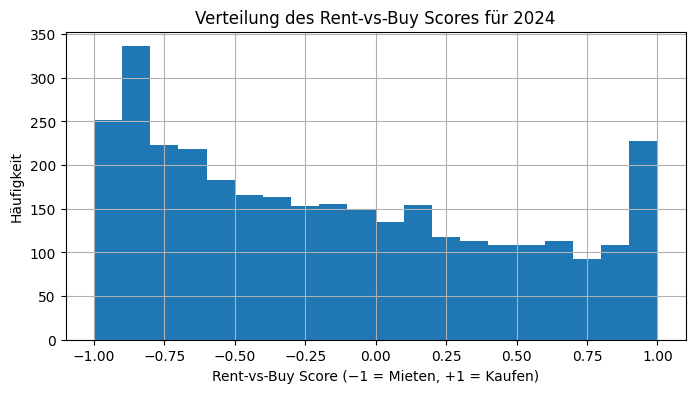

In [12]:
for year in sorted(df_empirica_regio["Jahr"].dropna().unique()):
    s = df_empirica_regio.loc[df_empirica_regio["Jahr"] == year, "Score"].dropna()
    if s.empty:
        continue

    plt.figure(figsize=(8, 4))
    plt.hist(s, bins=20, range=(-1, 1))
    plt.xlabel("Rent-vs-Buy Score (−1 = Mieten, +1 = Kaufen)")
    plt.ylabel("Häufigkeit")
    plt.title(f"Verteilung des Rent-vs-Buy Scores für {int(year)}")
    plt.grid(True)
    plt.show()